In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 'train.csv' dosyasını oku ve verileri df_train adlı bir Pandas veri çerçevesine yükle
df_train = pd.read_csv('train.csv')

In [ ]:
# Doğrulama Seti Oluştur
# 'test.csv' dosyasını df_valid adlı bir Pandas veri çerçevesine yükle
df_valid = pd.read_csv('test.csv')

# 'gender_submission.csv' dosyasını df_gender adlı bir Pandas veri çerçevesine yükle
df_gender = pd.read_csv('gender_submission.csv')

# df_valid ve df_gender'ı 'PassengerId' sütunu üzerinde birleştir
df_valid = pd.merge(df_valid, df_gender, on='PassengerId')

# 'Survived' sütununda eksik değerleri içeren satırları kaldır
df_valid.dropna(subset=['Survived'], inplace=True)

# 'Fare' sütununda eksik değerleri içeren satırları kaldır
df_valid.dropna(subset=['Fare'], inplace=True)

In [ ]:
def manual_preprocess_df(df):
    # Gereksiz sütunları (Name, PassengerId, Cabin, Ticket) kaldır
    df = df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1)

    # 'Embarked' sütunundaki kategorik değerleri sayısal değerlere dönüştür
    df['Embarked'] = df['Embarked'].map({
        'C' : 0,
        'Q' : 1,
        'S' : 2
    })

    # 'Sex' sütunundaki cinsiyet kategorilerini sayısal değerlere dönüştür
    df['Sex'] = df['Sex'].map({
        'male' : 0,
        'female' : 1
    })

    # 'Age' sütunundaki eksik değerleri sütunun ortalaması ile doldur
    df['Age'] = df['Age'].fillna(df['Age'].mean())

    # 'Embarked' sütunundaki eksik değerlere sahip satırları kaldır
    df.dropna(subset=['Embarked'], inplace=True)

    return df


In [ ]:
# Eğitim veri setini manuel olarak ön işleme fonksiyonu ile işle
df_train = manual_preprocess_df(df_train)

# Doğrulama veri setini manuel olarak ön işleme fonksiyonu ile işle
df_valid = manual_preprocess_df(df_valid)


In [ ]:
# Etiket ve Veri Bölme
def label_data_split(df):
    # 'Survived' sütununu hedef değişken olarak ayır
    y = df['Survived']

    # 'Survived' sütununu haricindeki tüm sütunları özellik değişkenleri olarak ayır
    x = df.loc[:, df.columns != 'Survived']

    # Özellik ve etiket verilerini içeren bir demet döndür
    return (x, y)


In [ ]:
# Eğitim - Test Bölme ve Karıştırma
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Eğitim veri setini karıştır
df_train = shuffle(df_train)

# Etiket ve özellik verilerini ayır
(labels, targets) = label_data_split(df_train)

# Veriyi eğitim ve test setlerine böl
# test_size=0.33 parametresi ile verinin %33'ü test setine ayrılır
x_train, x_test, y_train, y_test = train_test_split(labels, targets, test_size=0.33)


In [ ]:
# Veri Ölçekleme
from sklearn.preprocessing import StandardScaler

D = 7

# Özellik verilerini standart ölçekleme için bir StandardScaler nesnesine uygun hale getir
dataScaler = StandardScaler()

# Eğitim veri setini standart ölçekleme işlemine tabi tut
x_train = dataScaler.fit_transform(x_train)

# Test veri setini, eğitim veri setinde kullanılan ölçekleme parametrelerini kullanarak ölçekle
x_test = dataScaler.transform(x_test)




In [ ]:
# TF Keras Fonksiyonel API ile Model Oluşturma
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.models import Model

# Giriş katmanını tanımla, özellik sayısını (D) ve giriş sinyali boyutunu (1) belirle
i = Input(shape=(D, 1))

# İlk LSTM katmanı, 32 birimli ve aktivasyonu LeakyReLU olan bir dizi dönüşle oluştur
x = LSTM(32, return_sequences=True, activation=LeakyReLU(alpha=0.2))(i)
x = Dropout(0.2)(x)

# İkinci LSTM katmanı, 64 birimli ve aktivasyonu LeakyReLU olan bir dizi dönüşle oluştur
x = LSTM(64, return_sequences=True, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)

# Üçüncü LSTM katmanı, 128 birimli ve aktivasyonu LeakyReLU olan bir dizi dönüşle oluştur
x = LSTM(128, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)

# Tam bağlantılı (dense) çıkış katmanını tanımla, aktivasyonu sigmoid olan bir düğüm içerir
x = Dense(1, activation='sigmoid')(x)

# Modeli giriş ve çıkış katmanları kullanarak oluştur
model = Model(i, x)


In [ ]:
# Model Derleme
from tensorflow.keras.optimizers import Adam

# Modeli derle
model.compile(
    loss='binary_crossentropy',  # İkili sınıflandırma için çapraz entropi kaybı
    optimizer=Adam(learning_rate=0.0011),  # Adam optimizer kullanarak öğrenme oranını belirle
    metrics=['accuracy']  # Model performansını değerlendirmek için doğruluk metriği kullan
)


In [ ]:
# Erken Durdurma (Early Stopping) için Ayarlar
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback'i oluştur
# 'val_accuracy' metriğini izleyerek, 15 sabır (patience) süresince gelişme olmadığında eğitimi durdur
early_stop = EarlyStopping(monitor='val_accuracy', patience=15)


In [ ]:
# Model Eğitimi
r = model.fit(
    x_train,                 # Eğitim verisi
    y_train,                 # Eğitim etiketleri
    validation_data=(x_test, y_test),  # Doğrulama verisi
    epochs=150,              # Toplam eğitim döngüsü sayısı
    callbacks=[early_stop]   # Erken Durdurma callback'i kullanarak eğitimi kontrol et
)


Epoch 1/150
19/19 [==============================] - 5s 83ms/step - loss: 0.6863 - accuracy: 0.5782 - val_loss: 0.6671 - val_accuracy: 0.6395
Epoch 2/150
19/19 [==============================] - 1s 36ms/step - loss: 0.6713 - accuracy: 0.6067 - val_loss: 0.6509 - val_accuracy: 0.6395
Epoch 3/150
19/19 [==============================] - 1s 41ms/step - loss: 0.6611 - accuracy: 0.6067 - val_loss: 0.6411 - val_accuracy: 0.6395
Epoch 4/150
19/19 [==============================] - 1s 35ms/step - loss: 0.6493 - accuracy: 0.6034 - val_loss: 0.6278 - val_accuracy: 0.6259
Epoch 5/150
19/19 [==============================] - 1s 36ms/step - loss: 0.6322 - accuracy: 0.5916 - val_loss: 0.6229 - val_accuracy: 0.6633
Epoch 6/150
19/19 [==============================] - 1s 35ms/step - loss: 0.6176 - accuracy: 0.6303 - val_loss: 0.5872 - val_accuracy: 0.6395
Epoch 7/150
19/19 [==============================] - 1s 56ms/step - loss: 0.6061 - accuracy: 0.6471 - val_loss: 0.6168 - val_accuracy: 0.6803
Epoch 

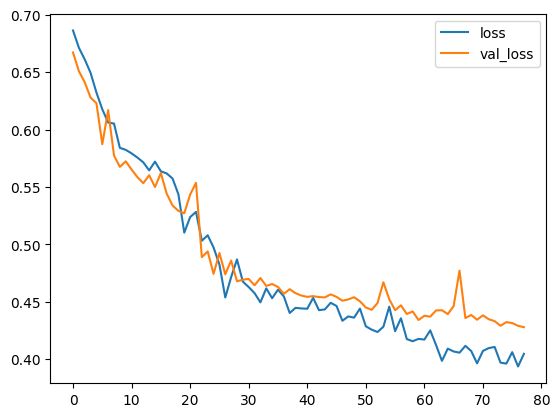

In [ ]:
# Kayıp (Loss) Grafiği Çizimi
plt.plot(r.history['loss'], label='loss')          # Eğitim seti kaybını çiz
plt.plot(r.history['val_loss'], label='val_loss')  # Doğrulama seti kaybını çiz

# Grafikteki çizgileri açıklamak için etiket ekle
plt.legend()


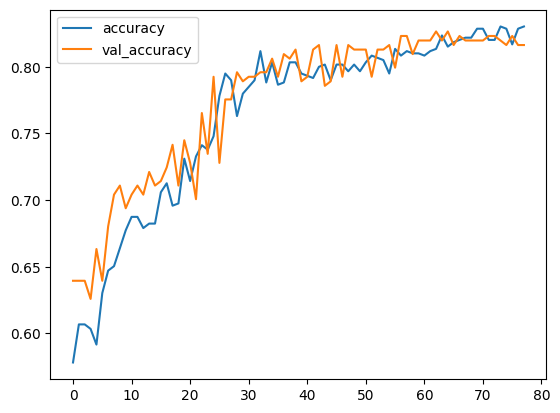

In [ ]:
# Doğruluk (Accuracy) Grafiği Çizimi
plt.plot(r.history['accuracy'], label='accuracy')          # Eğitim seti doğruluğunu çiz
plt.plot(r.history['val_accuracy'], label='val_accuracy')  # Doğrulama seti doğruluğunu çiz

# Grafikteki çizgileri açıklamak için etiket ekle
plt.legend()


In [ ]:
# Eğitim Verisi ile Model Değerlendirme
split_evals = model.evaluate(
    x_test,  # Eğitim veri seti
    y_test   # Eğitim etiketleri
)


10/10 [==============================] - 0s 5ms/step - loss: 0.4277 - accuracy: 0.8163


In [ ]:
# Birleştirilmiş Gönderim Örneği ile Model Değerlendirme
(x_valid, y_valid) = label_data_split(df_valid)  # Birleştirilmiş gönderim örneği için etiket ve özellik verilerini ayır

x_valid = dataScaler.transform(x_valid)  # Veriyi ölçeklendir

merged_evals = model.evaluate(
    x_valid,  # Birleştirilmiş gönderim örneği için özellik verileri
    y_valid   # Birleştirilmiş gönderim örneği için etiket verileri
)


14/14 [==============================] - 0s 5ms/step - loss: 0.3118 - accuracy: 0.9305


<BarContainer object of 4 artists>

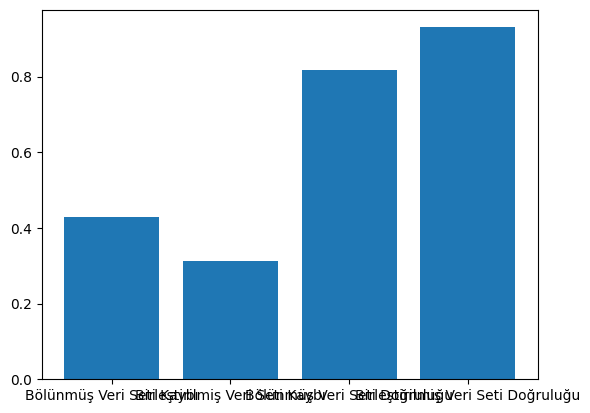

In [ ]:
# Performans Karşılaştırması Çubuk Grafiği Çizimi
labels = ["Bölünmüş Veri Seti Kaybı", "Birleştirilmiş Veri Seti Kaybı", "Bölünmüş Veri Seti Doğruluğu", "Birleştirilmiş Veri Seti Doğruluğu"]
values = [split_evals[0], merged_evals[0], split_evals[1], merged_evals[1]]

# Çubuk grafiği çiz
plt.bar(labels, values)


In [ ]:
# Tahmin İçin Test Veri Setini Okuma
prediction_df = pd.read_csv('test.csv')


In [ ]:
# Tahmin İçin Veriyi Manuel Olarak Ön İşleme
prediction_df_processed = manual_preprocess_df(prediction_df)


In [ ]:
# 'Fare' Sütunundaki Eksik Değerleri Ortalama ile Doldurma
prediction_df_processed['Fare'] = prediction_df_processed['Fare'].fillna(prediction_df_processed['Fare'].mean())


In [ ]:
# Tahmin İçin Veriyi Ölçekleme
x_prediction = dataScaler.transform(prediction_df_processed)


In [ ]:
# Modelin Tahmin Yapması
predictions = model.predict(
    x_prediction
)


14/14 [==============================] - 0s 5ms/step


In [ ]:
# 'df_gender' Veri Çerçevesinden Etiketleri Alma
labels = df_gender.to_numpy()[:, 1]


In [ ]:
# Tahmin Sonuçlarını Düzleştirme
pred = predictions.flatten()


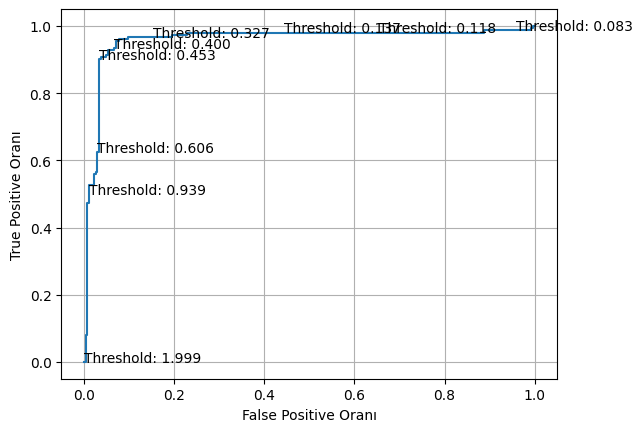

In [ ]:
# ROC Eğrisi Çizimi ve Eşik Değerlerinin Gösterimi
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Roc eğrisi için false positive (fp), true positive (tp) ve eşik değerlerini hesapla
fp, tp, threshold = roc_curve(labels, pred)

# Roc eğrisini çiz
plt.plot(fp, tp)
plt.xlabel("False Positive Oranı")
plt.ylabel("True Positive Oranı")

# Eşik değerlerini belirli aralıklarla eğri üzerinde göster
skip = 8
for i in range(0, len(threshold), skip):
    plt.text(fp[i], tp[i], f'Threshold: {threshold[i]:.3f}')

# Izgara ekleyerek daha iyi okunabilirlik sağla
plt.grid()
plt.show()


[[257   9]
 [ 15 137]]


<Axes: >

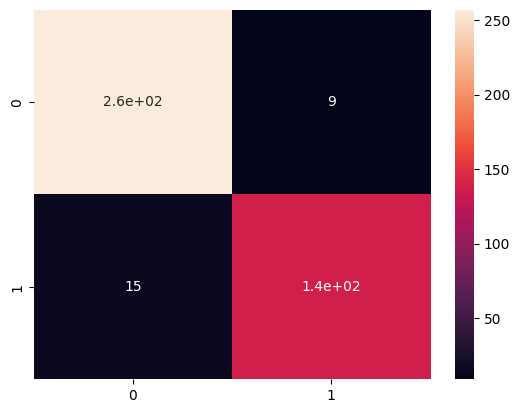

In [ ]:
# Karışıklık Matrisi Hesaplama ve Isı Haritası Oluşturma
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Belirlenen eşik değeri ile karışıklık matrisini hesapla
threshold = 0.453
cm = confusion_matrix(labels, pred > threshold)

# Karışıklık matrisini ekrana yazdır
print(cm)

# Seaborn kütüphanesi kullanarak karışıklık matrisini ısı haritası olarak çiz
sns.heatmap(cm, annot=True)



In [ ]:
# F1 Skoru Hesaplama
from sklearn.metrics import f1_score

# Belirlenen eşik değeri ile F1 skorunu hesapla
score = f1_score(labels, pred > threshold)

# Hesaplanan F1 skorunu ekrana yazdır
score


0.9194630872483222

In [ ]:
# Tahmin Sonuçlarını İçeren Veri Çerçevesi Oluşturma
result_df = pd.DataFrame(prediction_df)

# 'Survived' sütununu modelin tahmin sonuçları ile güncelle
result_df['Survived'] = predictions

# Eşik değeri üzerinden tahmin sonuçlarını 0 veya 1'e dönüştür
result_df['Survived'] = result_df['Survived'].apply(lambda x: 1 if x > threshold else 0)

# Veri çerçevesinin ilk birkaç satırını görüntüle
result_df.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [ ]:
# Elle Girilen Veriye Göre Tahmin Yapma

# Kullanıcı tarafından girilen bilgiler
cinsiyet = 'female'
yas = 38
bilet_ucreti = 71.2833
bindigi_yer = 'C'

# Kategorik verileri sayısal değerlere dönüştürme
cinsiyet = 0 if cinsiyet.lower() == 'male' else 1
bindigi_yer = {'C': 0, 'Q': 1, 'S': 2}.get(bindigi_yer.upper(), -1)

# 'bindigi_yer' değerinin geçerli olup olmadığını kontrol etme
if bindigi_yer == -1:
    print("'bindigi_yer' değeri geçersiz. Lütfen 'C', 'Q' veya 'S' kullanın.")
    exit()

# Yolcu verilerini içeren bir liste oluşturma
yolcu = [1, cinsiyet, yas, 1, 0, bilet_ucreti, bindigi_yer]  # Basitlik için Pclass=1 olarak varsayıyoruz

# Listeyi NumPy dizisine dönüştürme
yolcu = np.array(yolcu).reshape(1, -1)

# Yolcu verilerini eğitim sırasında kullanılan ölçekleyici ile ölçekleme
yolcu = dataScaler.transform(yolcu)

# Tahmin yapma
tahmin = model.predict(yolcu)

# Tahmini yazdırma
print("Hayatta Kalma Olasılığı:", tahmin[0, 0])


1/1 [==============================] - 0s 23ms/step
Hayatta Kalma Olasılığı: 0.9757461


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Modeli JSON Formatında Kaydetme

# Modeli JSON formatına çevirme
model_json = model.to_json()

# Oluşturulan JSON modelini "model.json" dosyasına yazma
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [199]:
# Modeli H5 Formatında Kaydetme

# Eğitilmiş modeli "my_model.h5" adlı bir H5 dosyasına kaydetme
model.save("my_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs==2.8.4


  Using cached tensorflowjs-2.8.4-py3-none-any.whl (63 kB)
  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  Using cached tensorflow_hub-0.9.0-py2.py3-none-any.whl (103 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: Could not build wheels for h5py, which is required to install pyproject.toml-based projects


In [ ]:
!pip install --upgrade tensorflowjs


In [ ]:
!pip install jax==0.4.21
!pip install jaxlib==0.1.77


ERROR: Could not find a version that satisfies the requirement jaxlib==0.1.77 (from versions: 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.6, 0.4.7, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.15, 0.4.16, 0.4.17, 0.4.18, 0.4.19, 0.4.20, 0.4.21, 0.4.22, 0.4.23)
ERROR: No matching distribution found for jaxlib==0.1.77


In [ ]:
import tensorflowjs as tfjs

# Keras modelini TensorFlow.js formatına çevirip "../Model" dizinine kaydetme
tfjs.converters.save_keras_model(model, '../Model')


In [ ]:
# Ölçekleyici Bilgilerini Kaydetme
import json
# Ölçekleyici bilgilerini içeren bir sözlük oluşturma
scaler_info = {
    'ortalama': dataScaler.mean_.tolist(),
    'ölçek': dataScaler.scale_.tolist()
}

# Oluşturulan sözlüğü "scaler_info.json" adlı bir JSON dosyasına yazma
with open("scaler_info.json", "w") as json_file:
    json.dump(scaler_info, json_file)
